Steve Harris
Working through Chapter 2 
2023-12-18

First we need a generative model that counts the number of ways something comes about


In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

Let's take a sequence of observations "WLWL"
Let's define a 'globe' (aka dice) with a certain number of SIDES
In the video, McElreath works with a four sided die (the simplest 3 dimensional object).

We don't know how many of those sides contain water
But we have our data, the observations above.
So we imagine tossing the globe (dice), and evaluate the number of ways we could see those data across our range of hypotheses.

The hypotheses are our prior.
We start with some presumption of which hypotheses are more or less likely.
In this case, we say the prior is _flat_ (or uniform) because we consider each hypothesis equally likely.

Let's start with a 6 sided dice
Let's consider the simplest hypothesis that all the world is water

Then the first observation "W" (from "WLWL") is _certain_ because all the sides are "W"
But the next observation "L" is _impossible_ (also because all the sides are "W")
So there are zero ways to achieve this

Now let's imagine 1 side is "L" and the rest are "W"
Then there are 

- 5 ways to get the first observation "W"
- 1 way to get the second observation "L"
- 5 ways to get the third observation "W"
- 1 way to get the fourth

So that's $5 \times 1 \times 5 \times 1$ which is 25 ways in total

And now we can repeat this for each hypothesised proportion of water

In [4]:
SIDES_TOTAL = 9
# Hypotheses ... (aka prior)
SIDES_WATER = [0,1,2,3,4,5,6,7,8,9]

# Data
OBSERVATIONS = "WLWLWWWLW"

hypotheses_paths = []

# now we loop over all possible hypotheses (i.e. the prior)
# we do that by imagining a different dice for each hypothesis
for hypothesis in SIDES_WATER:
    # create the hypothesised dice
    DICE = list((hypothesis * "W") + ((SIDES_TOTAL - hypothesis) * "L"))
    DICE = np.array(DICE) # convert to an array
    # now using that dice, let's count the number of ways the observed data could arise
    ways = []
    for obs in OBSERVATIONS:
        forks = (DICE == obs).sum()
        ways.append(forks)
        # multiply all the forks together to get the number of possible paths
        paths = np.prod(np.array(ways))
        # and because this step is multiplication then we can easily append another data point by multiplying one more time
    hypotheses_paths.append((hypothesis, paths))
    print("".join(DICE), hypothesis, paths)
    

LLLLLLLLL 0 0
WLLLLLLLL 1 512
WWLLLLLLL 2 21952
WWWLLLLLL 3 157464
WWWWLLLLL 4 512000
WWWWWLLLL 5 1000000
WWWWWWLLL 6 1259712
WWWWWWWLL 7 941192
WWWWWWWWL 8 262144
WWWWWWWWW 9 0


We need to standardise to get probabilities and avoid having huge numbers
So we will just divide each hypothesis' paths by the total paths

And if you throw the globe (dice) one more time and gather one more datum then you can simply multiply these existing paths by the number of ways that particular hypothesis could generate that additional throw.

So more paths means that particular hypothesis is more likely.
Specifically, if we observe `WLWLWWWLW` then a die with 9 out of 9 'land' sides is impossible, and one with 6 out of 9 'water' sides is most possible.

Now let's write a little machine (aka function) that works in the _opposite_ direction, and makes samples based on the a hypothesis. This will be our _generative simulator_.

In [4]:
def sim_globe(rolls, water_sides, total_sides, verbose=False):
    DICE = list((water_sides * "W") + ((total_sides - water_sides) * "L"))
    DICE = np.array(DICE)
    obs = np.random.choice(DICE, rolls, replace=True)
    if verbose:
        print(f"Rolling dice {''.join(DICE)} {rolls} times, you rolled '{''.join(obs)}'")
    return obs
        

In [5]:
sim_globe(rolls=9, water_sides=6, total_sides=9, verbose=True)

Rolling dice WWWWWWLLL 9 times, you rolled 'WWWWWWWWW'


array(['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'], dtype='<U1')

Now use this generator multiple times ...

In [6]:
np.array([sim_globe(rolls=8, water_sides=6, total_sides=9) for  _ in range(10**2)])

array([['W', 'W', 'W', 'L', 'W', 'W', 'W', 'L'],
       ['W', 'W', 'W', 'W', 'L', 'W', 'W', 'W'],
       ['W', 'W', 'W', 'W', 'W', 'L', 'W', 'W'],
       ['L', 'W', 'W', 'W', 'L', 'L', 'W', 'L'],
       ['W', 'L', 'L', 'W', 'W', 'W', 'L', 'W'],
       ['L', 'L', 'W', 'W', 'L', 'W', 'W', 'W'],
       ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['L', 'W', 'L', 'W', 'W', 'W', 'L', 'L'],
       ['W', 'L', 'W', 'L', 'W', 'W', 'W', 'W'],
       ['L', 'W', 'W', 'W', 'W', 'L', 'W', 'L'],
       ['W', 'W', 'W', 'L', 'L', 'L', 'W', 'W'],
       ['L', 'L', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['W', 'L', 'W', 'W', 'W', 'L', 'W', 'W'],
       ['W', 'W', 'W', 'L', 'L', 'W', 'W', 'W'],
       ['L', 'W', 'L', 'L', 'L', 'W', 'W', 'L'],
       ['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
       ['L', 'W', 'W', 'L', 'W', 'L', 'W', 'L'],
       ['W', 'W', 'W', 'W', 'W', 'L', 'W', 'L'],
       ['L', 'W', 'W', 'W', 'L', 'W', 'L', 'W'],
       ['W', 'W', 'W', 'L', 'W', 'W', 'W', 'W'],
       ['W', 'W', 'W

Up to this point, we have done nothing more than count the number of ways our hypothesis (the number of 'water' sides on the dice), can generate the observed data via the imposed model (the concept of a dice). We can count more efficiently if we use a little maths (see 'Counting deaths').

Let's redefine sim_globe analytically.
Note that we now drop the concept of the globe being a dice, and the dice having a specific resolution. 
Instead we simply provide the proportion of the globe (an infinite sided dice) covered with water.

In [2]:
def sim_globe(N, p, verbose=False):
    """
    Simulate N rolls of a dice with a specific proportion covered by water. 
    p: float
        The proportion of water
    N: int
        Number of globe tosses to simulate
    """
    options = list("WL") # water or land
    return np.random.choice(options, size=N, p=np.array([p, 1-p]), replace=True)

In [3]:
from pprint import pprint
pprint([sim_globe(N=9, p=0.7).tolist() for _ in range(10)])

[['W', 'W', 'W', 'L', 'L', 'W', 'L', 'W', 'L'],
 ['W', 'L', 'W', 'W', 'W', 'W', 'L', 'W', 'L'],
 ['W', 'L', 'W', 'L', 'W', 'W', 'W', 'W', 'W'],
 ['W', 'L', 'W', 'W', 'L', 'W', 'L', 'L', 'W'],
 ['W', 'W', 'W', 'L', 'L', 'L', 'W', 'W', 'W'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'L', 'L', 'W'],
 ['W', 'W', 'L', 'W', 'W', 'W', 'W', 'W', 'L'],
 ['W', 'W', 'W', 'W', 'W', 'W', 'L', 'L', 'W'],
 ['L', 'W', 'L', 'W', 'W', 'W', 'W', 'W', 'W'],
 ['L', 'W', 'L', 'W', 'L', 'W', 'W', 'W', 'L']]


## Test before you est(imate)

1. Code a generative simulation
2. Code an estimator
3. Test (2) with (1) to ensure things are behaving

### 1. Code a generative simulation

As $N\rightarrow\infty$, then should converge to a known $p$

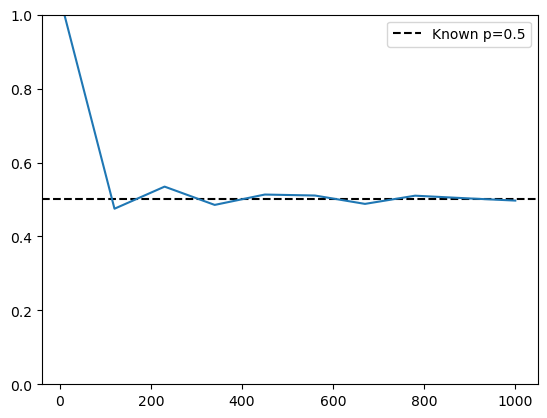

In [6]:
# Large N should converge to known p
known_p = 0.5

simulated_ps = []
sample_sizes = np.linspace(10, 1_000, 10)
for N in sample_sizes:
    simulated_p = np.sum(sim_globe(p=known_p, N=int(N)) == 'W') / N
    simulated_ps.append(simulated_p)
    
plt.axhline(known_p, label=f"Known p={known_p}", color='k', linestyle='--')
plt.ylim(0,1);
plt.legend();
plt.plot(sample_sizes, simulated_ps);

Check simple and predictable boundary conditions

In [35]:
pprint(sim_globe(p=0, N=10).tolist())

['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']


In [36]:
pprint(sim_globe(p=1, N=10).tolist())

['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W']


### 2. Code the estimator

In [38]:
RESOLUTION=4 # 4 sided dice

def count_paths(p, n_W, n_L, resolution=RESOLUTION):
    water_sides = RESOLUTION * p
    land_sides = RESOLUTION * (1-p)
    return (water_sides ** n_W) * (land_sides ** n_L)
    
def compute_posterior(obs, resolution=RESOLUTION, ax=None):
    """
    Estimator takes the observed data, the prior, and the model and returns the posterior
    """
    n_W = len(obs.replace("L",""))
    n_L = len(obs) - n_W
    
    # the possible number of sides with water
    hypotheses = np.arange(start=0, stop=resolution, step=1)
    # the proportions of the globe covered with water
    proportions_water = hypotheses / resolution
    
    n_possible_ways = np.array([
        count_paths(p, n_W, n_L, resolution)
        for p in proportions_water        
    ])
    
    # I think this is the likelihood _not_ the posterior
    posterior_water = n_possible_ways / n_possible_ways.sum()
    # TODO: we're missing a step where we multiply the likelihood by the prior
    # we get away with it b/c the prior is uniform/flat
    return posterior_water, proportions_water
    
    

In [ ]:
posterior, probs = compute_posterior(observations, resolution=resolution)
    if ax is not None:
        plt.sca(ax)
    plt.bar(x=probs, height=posterior, width= .9 / resolution, color='k')
    plt.xticks(probs[::2], rotation=45);
    plt.ylabel("probability")
    plt.xlabel("proportion water")
    plt.title(f"Posterior Calculated\nfrom # Samples: {len(observations)}")

In [ ]:
posterior, probs = compute_posterior(observations, resolution=resolution)
    if ax is not None:
        plt.sca(ax)
    plt.bar(x=probs, height=posterior, width= .9 / resolution, color='k')
    plt.xticks(probs[::2], rotation=45);
    plt.ylabel("probability")
    plt.xlabel("proportion water")
    plt.title(f"Posterior Calculated\nfrom # Samples: {len(observations)}")

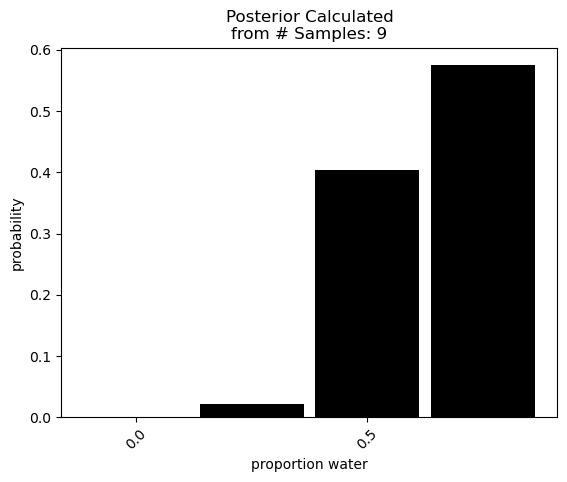

In [51]:
RESOLUTION=4
obs = "WLWLWLWWW"

def plot_posterior(obs, resolution=RESOLUTION, ax=None):
    posterior, probs = compute_posterior(obs, resolution=resolution)
    if ax is not None:
        plt.sca(ax)
    plt.bar(x=probs, height=posterior, width= .9 / resolution, color='k')
    plt.xticks(probs[::2], rotation=45);
    plt.ylabel("probability")
    plt.xlabel("proportion water")
    plt.title(f"Posterior Calculated\nfrom # Samples: {len(obs)}")
    
plot_posterior(obs, resolution=RESOLUTION)

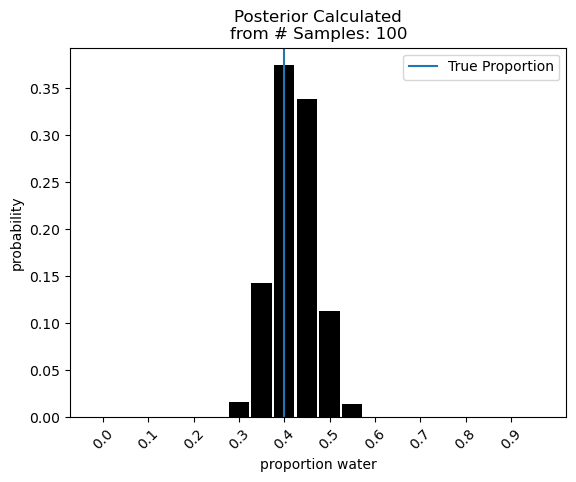

In [53]:
np.random.seed(2)
p = 0.4
obs = "".join(sim_globe(N=100, p=p))
plot_posterior(obs, resolution=20)
plt.axvline(p, color='C0', label='True Proportion')
plt.legend()


## Moving from an N-sided globe to an infinitely sided globe
As we increase the resoltuon of the globe,
- there are more bars/finer-grained resolution
- bars get shorter
- the overall probability sum (area under the curve) remains unchanged at `1`


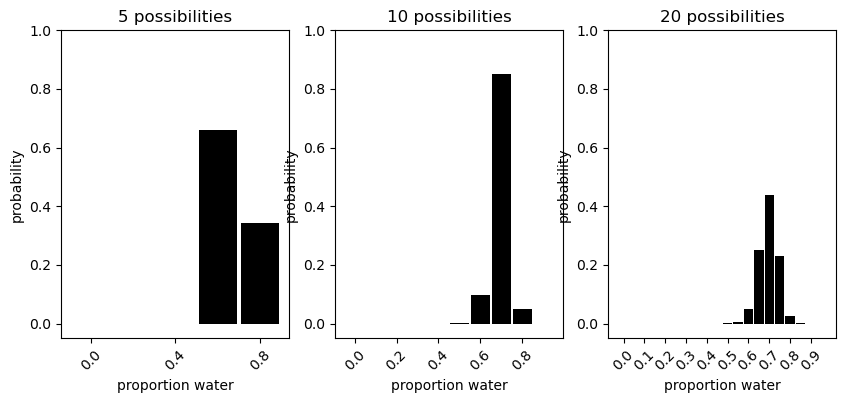

In [55]:
np.random.seed(12)
p=0.7
simulated_obs = "".join(sim_globe(N=100, p=p))
_, axs = plt.subplots(1,3, figsize=(10,4))
for ii, possibilites in enumerate([5,10,20]):
    plot_posterior(simulated_obs, resolution=possibilites, ax=axs[ii])
    plt.ylim([-0.05, 1])
    axs[ii].set_title(f"{possibilites} possibilities")

### Beta distribution

An analytical function that gives us the probability density function as resolution (number of possibilities) $\rightarrow \infty$

$$
p=\frac{(W+L+1)!}{W!L!} p^{W}(1-p)^{L}
$$

where $\frac{(W+L+1)!}{W!L!}$ is a normalising constant to make the distribution sum to $1$.

In [56]:
from scipy.special import factorial

def beta(W, L, p):
    return factorial(W+L+1) / (factorial(W) * factorial(L)) * p ** W * (1-p) ** L


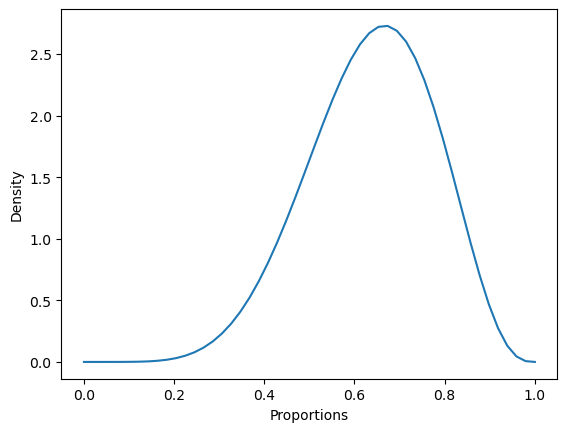

In [66]:
# Quick checkt to see how the function works
proportions = np.linspace(0,1,num=50)
probs = beta(W=6,L=3, p=proportions)
fig, ax = plt.subplots()
ax.plot(proportions, probs)
plt.ylabel("Density")
plt.xlabel("Proportions")
plt.show()

In [67]:
def plot_beta_from_obs(obs: str, resolution: int = 50, **plot_kwargs):
    """Calculate posterior from a string of observations"""
    n_W=len(obs.replace("L", ""))
    n_L=len(obs) - n_W
    proportions = np.linspace(0,1,num=resolution)
    
    probs=beta(n_W, n_L, p=proportions)
    plt.plot(proportions, probs, **plot_kwargs)
    plt.yticks([])
    plt.title(obs)
    

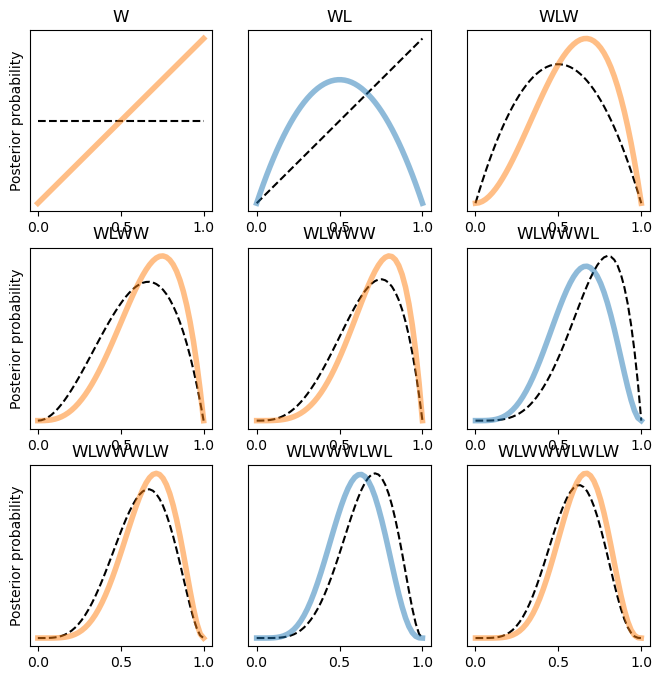

In [69]:
obs = "WLWWWLWLW"
fig, axs = plt.subplots(3,3,figsize=(8,8))
for ii in range(9):
    ax = axs[ii // 3][ii % 3]
    plt.sca(ax)
    # first plot the previous distribution
    if ii > 0:
        plot_beta_from_obs(obs[:ii], color='k', linestyle='--')
    else:
        # first observation, no previous data
        plot_beta_from_obs('', color='k', linestyle='--')
    
    # now plot this distribution (remember that the python slice [:ii] would have excluded the current observation in
    # the prev step hence ii+1 here
    color = 'C1' if obs[ii] == 'W' else 'C0'
    plot_beta_from_obs(obs[:ii+1], color=color, linewidth=4, alpha=0.5)
    
    if not ii % 3:
        plt.ylabel("Posterior probability")